In [1]:
!git clone https://github.com/lphucthinh40/cmpe249-object-detection-hw

Cloning into 'cmpe249-object-detection-hw'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 66 (delta 8), reused 61 (delta 6), pack-reused 0
Unpacking objects: 100% (66/66), done.


In [6]:
%cd cmpe249-object-detection-hw

/content/cmpe249-object-detection-hw


## Install Detectron 2

In [1]:
# !pip install pyyaml==5.1

# import torch
# TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
# CUDA_VERSION = torch.__version__.split("+")[-1]
# print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [2]:
import torch
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# import matplotlib
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

## Prepare Argoverse Dataset

In [7]:
# Argoverse classes for detection
CLASSES = ['person',  'bicycle',  'car',  'motorcycle',  'bus',  'truck',  'traffic_light',  'stop_sign']

In [8]:
from utils.general import download, Path

dataset_dir = Path('./datasets/Argoverse')
images_dir = dataset_dir / 'Argoverse-1.1'/ 'images'
annotations_dir = dataset_dir / 'Argoverse-HD/annotations'

In [9]:
# download argoverse dataset
url = 'https://argoverse-hd.s3.us-east-2.amazonaws.com/Argoverse-HD-Full.zip'
download(url, dir=dataset_dir, delete=True)

  0%|          | 0.00/29.2G [00:00<?, ?B/s]

Unzipping datasets/Argoverse/Argoverse-HD-Full.zip...


In [10]:
# rename 'tracking' folder to 'images'
(dataset_dir / 'Argoverse-1.1' / 'tracking').rename(dataset_dir / 'Argoverse-1.1' / 'images')

In [11]:
from detectron2.structures import BoxMode
from tqdm import tqdm
import json

label_count = 0
class_count = {cls:0 for cls in CLASSES}
def get_argoverse_dicts(annotations_path, images_path):
    global label_count, class_count
    with open(annotations_path) as f:
        metadata = json.load(f)

    label_count = len(metadata['annotations'])
    dataset_dicts = []
    labels = {}
    for annot in tqdm(metadata['annotations'], desc=f"Generating custom dataset dict for detectron2..."):
        img_id = annot['image_id']
        img_name = metadata['images'][img_id]['name']
        img_height = metadata['images'][img_id]['height']
        img_width = metadata['images'][img_id]['width']
        
        cls = annot['category_id']
        x, y, width, height = annot['bbox']
        obj = {
                "bbox": [x, y, width, height],
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": cls,
        }
        class_count[CLASSES[cls]] = class_count[CLASSES[cls]] + 1
        img_dir = images_path / metadata['seq_dirs'][metadata['images'][img_id]['sid']]
        
        if img_id not in labels:
            labels[img_id] = {
                "file_name": str(img_dir / img_name),
                "image_id": img_id,
                "height": img_height,
                "width": img_width,
                "annotations": [],
            }
        labels[img_id]["annotations"].append(obj)
    return list(labels.values())

In [12]:
# Register Dataset
for d in ["train", "val"]:
    DatasetCatalog.register("argo_" + d, lambda d=d: get_argoverse_dicts(str(annotations_dir) + f"/{d}.json", images_dir))
    MetadataCatalog.get("argo_" + d).set(thing_classes=CLASSES)
argoverse_metadata = MetadataCatalog.get("argo_train")

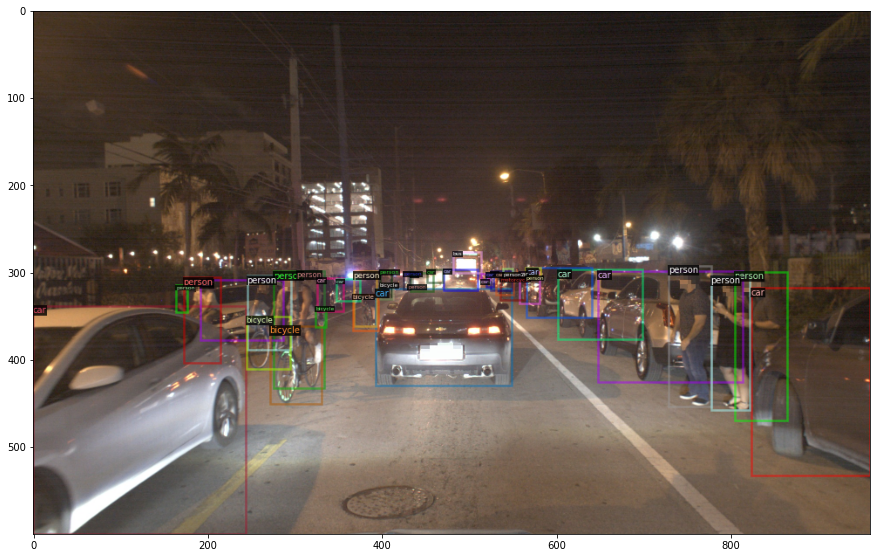

In [15]:
Check a sample image from dataset dict
dataset_dicts = get_argoverse_dicts(annotations_dir / "train.json", images_dir)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=argoverse_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())

In [16]:
dataset_dicts[0]

{'annotations': [{'bbox': [898, 584, 251, 228],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 2},
  {'bbox': [459, 425, 408, 362],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 5},
  {'bbox': [416, 272, 27, 72],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 6},
  {'bbox': [655, 283, 25, 71],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 6},
  {'bbox': [211, 395, 20, 52],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 6},
  {'bbox': [306, 422, 17, 39],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 6},
  {'bbox': [173, 558, 162, 75],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 5},
  {'bbox': [368, 583, 63, 39],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 5},
  {'bbox': [4, 597, 93, 40],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 2},
  {'bbox': [81, 591, 94, 44],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 2},
  {'bbox': [945, 424, 15, 37],
   'bbox_mode': <BoxMode.XYWH_AB

In [17]:
print(f"Argoverse-1.1 Dataset | Image Count: {len(dataset_dicts)}, Label Count: {label_count}")
print(f"Classes Count:")
for cls, count in class_count.items():
  print(f"\t{cls}: {count}")

Argoverse-1.1 Dataset | Image Count: 39372, Label Count: 771774
Classes Count:
	person: 89795
	bicycle: 8372
	car: 486022
	motorcycle: 4090
	bus: 6532
	truck: 76494
	traffic_light: 95018
	stop_sign: 5451


In [18]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("argo_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0005  # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.MAX_ITER = 3000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.GAMMA = 0.00      # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(CLASSES)  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/15 03:46:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Generating custom dataset dict for detectron2...: 100%|██████████| 771774/771774 [00:08<00:00, 86971.25it/s] 


[11/15 03:46:54 d2.data.build]: Removed 0 images with no usable annotations. 39372 images left.
[11/15 03:46:56 d2.data.build]: Distribution of instances among all 8 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    person     | 89795        |  bicycle   | 8372         |    car     | 486022       |
|  motorcycle   | 4090         |    bus     | 6532         |   truck    | 76494        |
| traffic_light | 95018        | stop_sign  | 5451         |            |              |
|     total     | 771774       |            |              |            |              |
[11/15 03:46:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/15 03:46:56 d2.data.build]: Using training sampler TrainingSampler
[11/1

[Checkpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...
model_final_280758.pkl: 167MB [00:07, 21.0MB/s]                           
Successfully downloaded /root/.torch/iopath_cache/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl. 167266879 bytes.
URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl cached in /root/.torch/iopath_cache/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl
Reading a file from 'Detectron2 Model Zoo'
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but

[11/15 03:47:15 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/15 03:47:28 d2.utils.events]:  eta: 0:27:43  iter: 19  total_loss: 2.217  loss_cls: 0.9389  loss_box_reg: 0.8265  loss_rpn_cls: 0.05959  loss_rpn_loc: 0.3213  time: 0.5490  data_time: 0.0440  lr: 0.0005  max_mem: 4744M
[11/15 03:47:39 d2.utils.events]:  eta: 0:27:58  iter: 39  total_loss: 1.772  loss_cls: 0.5968  loss_box_reg: 0.7458  loss_rpn_cls: 0.05447  loss_rpn_loc: 0.3521  time: 0.5513  data_time: 0.0147  lr: 0.0005  max_mem: 4744M
[11/15 03:47:50 d2.utils.events]:  eta: 0:27:37  iter: 59  total_loss: 1.623  loss_cls: 0.4991  loss_box_reg: 0.7269  loss_rpn_cls: 0.05268  loss_rpn_loc: 0.3356  time: 0.5525  data_time: 0.0148  lr: 0.0005  max_mem: 4744M
[11/15 03:48:01 d2.utils.events]:  eta: 0:27:36  iter: 79  total_loss: 1.56  loss_cls: 0.4885  loss_box_reg: 0.6658  loss_rpn_cls: 0.05133  loss_rpn_loc: 0.3124  time: 0.5562  data_time: 0.0151  lr: 0.0005  max_mem: 4744M
[11/15 03:48:13 d2.utils.events]:  eta: 0:27:31  iter: 99  total_loss: 1.415  loss_cls: 0.4201  loss_box_reg:

Saving checkpoint to ./output/model_final.pth


[11/15 04:15:37 d2.utils.events]:  eta: 0:00:00  iter: 2999  total_loss: 0.9438  loss_cls: 0.2664  loss_box_reg: 0.4072  loss_rpn_cls: 0.02559  loss_rpn_loc: 0.2566  time: 0.5657  data_time: 0.0152  lr: 0.0005  max_mem: 4744M
[11/15 04:15:37 d2.engine.hooks]: Overall training speed: 2998 iterations in 0:28:16 (0.5657 s / it)
[11/15 04:15:37 d2.engine.hooks]: Total training time: 0:28:18 (0:00:02 on hooks)


# Perform Inference Step

In [20]:
# Load trained weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
predictor = DefaultPredictor(cfg)

[Checkpointer] Loading from ./output/model_final.pth ...


Generating custom dataset dict for detectron2...: 100%|██████████| 253941/253941 [00:03<00:00, 69627.52it/s]
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


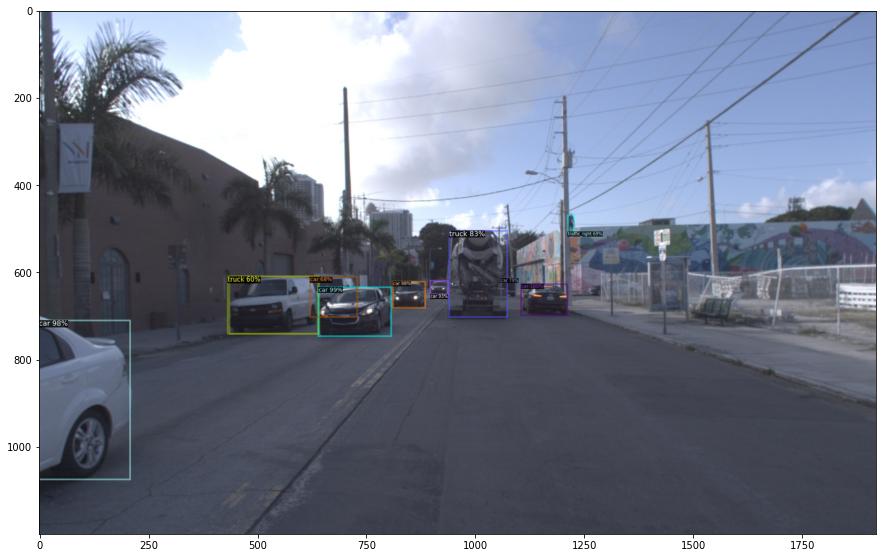

In [25]:
# Perform inference on random image from validation set
from detectron2.utils.visualizer import ColorMode
val_dataset_dicts = get_argoverse_dicts(annotations_dir / "val.json", images_dir)
for d in random.sample(val_dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=argoverse_metadata, 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())

## COCO Evaluation

In [26]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("argo_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "argo_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[11/15 04:19:38 d2.evaluation.coco_evaluation]: Trying to convert 'argo_val' to COCO format ...
[11/15 04:19:38 d2.data.datasets.coco]: Converting annotations of dataset 'argo_val' to COCO format ...)


Generating custom dataset dict for detectron2...: 100%|██████████| 253941/253941 [00:03<00:00, 70934.15it/s] 


[11/15 04:19:42 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[11/15 04:20:17 d2.data.datasets.coco]: Conversion finished, #images: 15055, #annotations: 253941
[11/15 04:20:17 d2.data.datasets.coco]: Caching COCO format annotations at './output/argo_val_coco_format.json' ...


Generating custom dataset dict for detectron2...: 100%|██████████| 253941/253941 [00:02<00:00, 103569.66it/s]


[11/15 04:20:29 d2.data.build]: Distribution of instances among all 8 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    person     | 32839        |  bicycle   | 1150         |    car     | 146990       |
|  motorcycle   | 1049         |    bus     | 11448        |   truck    | 19301        |
| traffic_light | 39237        | stop_sign  | 1927         |            |              |
|     total     | 253941       |            |              |            |              |
[11/15 04:20:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/15 04:20:29 d2.data.common]: Serializing 15055 elements to byte tensors and concatenating them all ...
[11/15 04:20:30 d2.data.common]: Serialized dataset takes 11.90 MiB
[11/15 04:20:30 d2.evaluation.

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[11/15 04:20:31 d2.evaluation.evaluator]: Inference done 11/15055. Dataloading: 0.0121 s/iter. Inference: 0.0704 s/iter. Eval: 0.0004 s/iter. Total: 0.0829 s/iter. ETA=0:20:47
[11/15 04:20:36 d2.evaluation.evaluator]: Inference done 70/15055. Dataloading: 0.0140 s/iter. Inference: 0.0702 s/iter. Eval: 0.0004 s/iter. Total: 0.0846 s/iter. ETA=0:21:07
[11/15 04:20:41 d2.evaluation.evaluator]: Inference done 131/15055. Dataloading: 0.0134 s/iter. Inference: 0.0702 s/iter. Eval: 0.0003 s/iter. Total: 0.0841 s/iter. ETA=0:20:54
[11/15 04:20:46 d2.evaluation.evaluator]: Inference done 192/15055. Dataloading: 0.0131 s/iter. Inference: 0.0702 s/iter. Eval: 0.0003 s/iter. Total: 0.0838 s/iter. ETA=0:20:44
[11/15 04:20:51 d2.evaluation.evaluator]: Inference done 252/15055. Dataloading: 0.0131 s/iter. Inference: 0.0701 s/iter. Eval: 0.0003 s/iter. Total: 0.0837 s/iter. ETA=0:20:38
[11/15 04:20:56 d2.evaluation.evaluator]: Inference done 312/15055. Dataloading: 0.0133 s/iter. Inference: 0.0700 s/i